In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf # pip install yfinance
import matplotlib.pyplot as plt # pip install matplotlib
import calmap # pip install calmap
import seaborn as sns
from optimization import optimize_parameters

In [22]:
symbol1 = 'DAL'
symbol2 = 'AAL'
# These two companies are in the sam industry, and are competitors. They should tend to move together and exhibit a mean-reverting behavior making trading the two a possible opportunity for generating alpha through statistical arbitrage.

start_date = '2010-01-01'
end_date = '2023-04-01'

data1 = yf.download(symbol1, start='2010-01-01', end='2023-04-01')
data2 = yf.download(symbol2, start='2010-01-01', end='2023-04-01')

best_params = optimize_parameters(symbol1, symbol2, start_date, end_date)

if best_params is not None:
    print(f'Optimal parameters: rolling window size = {best_params[0]}, z-score threshold = {best_params[1]}')
else:
    print("No optimal parameters found.")

returns1 = np.log(data1['Adj Close']).diff()
returns2 = np.log(data2['Adj Close']).diff()

spread = returns1 - returns2

zscore = (spread - spread.rolling(window=20).mean()) / spread.rolling(window=20).std()

signals = pd.Series(0, index=zscore.index)
signals[zscore > 1] = 1
signals[zscore < -1] = -1
signals[(zscore > -1) & (zscore < 1)] = 0

positions1 = signals.copy()
positions2 = -signals.copy()

positions = pd.concat([positions1, positions2], axis=1)
positions.columns = [symbol1, symbol2]

asset1_returns = positions1.shift(1) * returns1
asset2_returns = positions2.shift(1) * returns2
portfolio_returns = asset1_returns + asset2_returns

cumulative_returns = (1 + portfolio_returns).cumprod()

total_return = (cumulative_returns[-1] - 1) * 100
annualized_return = ((1 + total_return / 100) ** (252 / len(cumulative_returns)) - 1) * 100
volatility = np.std(portfolio_returns, ddof=1) * np.sqrt(252) * 100
with np.errstate(divide='ignore', invalid='ignore'):
    sharpe_ratio = annualized_return / volatility
max_drawdown = 100 * ((cumulative_returns / cumulative_returns.cummax()) - 1).min()

print(f'Total return: {total_return:.2f}%')
print(f'Annualized return: {annualized_return:.2f}%')
print(f'Volatility: {volatility:.2f}%')
print(f'Sharpe ratio: {sharpe_ratio:.2f}')
print(f'Max drawdown: {max_drawdown:.2f}%')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
No optimal parameters found.
Total return: 61.63%
Annualized return: 3.70%
Volatility: 17.29%
Sharpe ratio: 0.21
Max drawdown: -67.13%


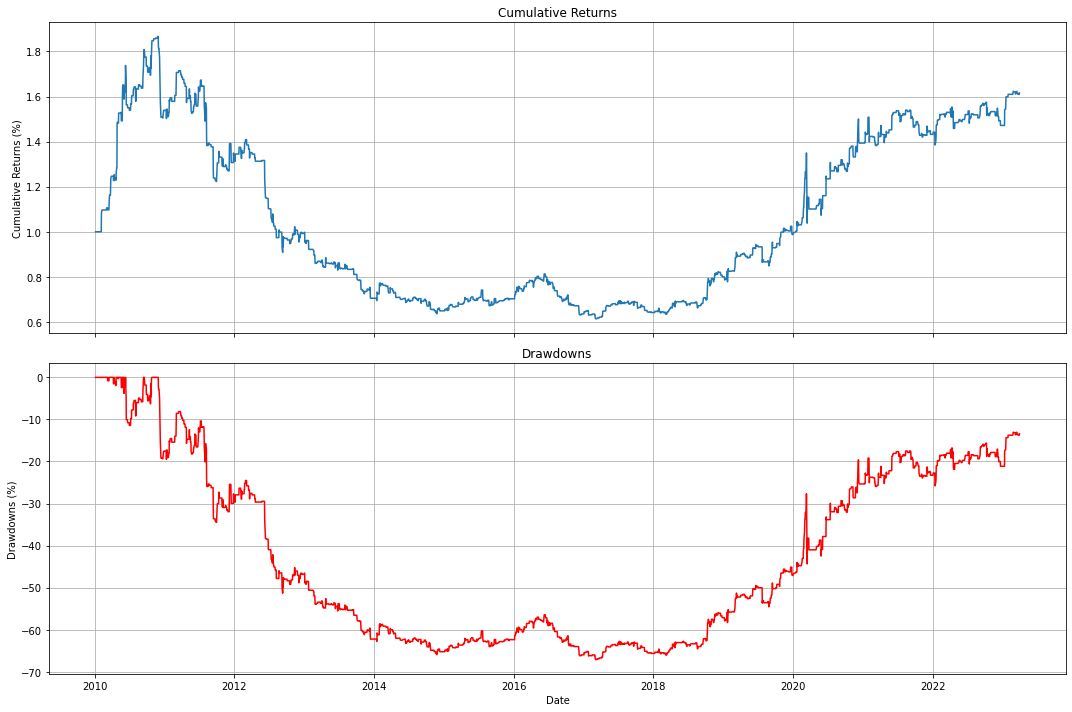

In [23]:
# Calculate drawdowns over time
drawdowns = 100 * (cumulative_returns / cumulative_returns.cummax() - 1)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

# Plot the cumulative returns
ax1.plot(cumulative_returns)
ax1.set_title('Cumulative Returns')
ax1.set_ylabel('Cumulative Returns (%)')
ax1.grid()

# Plot the drawdowns
ax2.plot(drawdowns, color='red')
ax2.set_title('Drawdowns')
ax2.set_ylabel('Drawdowns (%)')
ax2.set_xlabel('Date')
ax2.grid()

# Display the figure
plt.tight_layout()
plt.show()

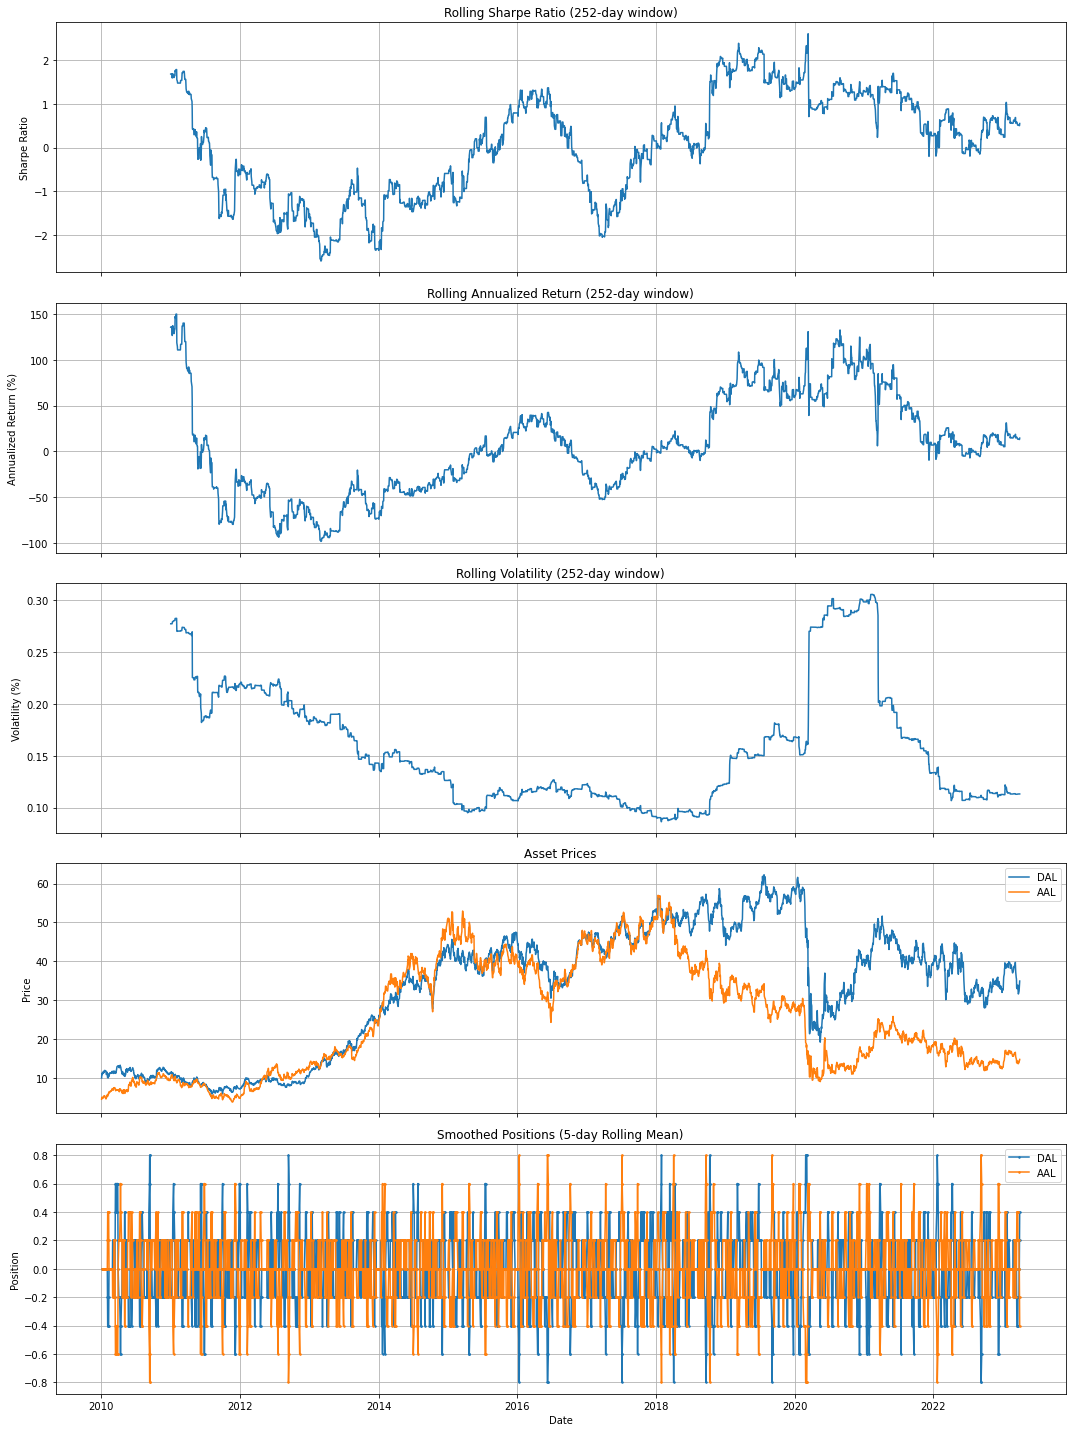

In [24]:
# Calculate rolling Sharpe ratio, annualized return, and volatility
rolling_sharpe_ratio = (portfolio_returns.rolling(window=252).mean() / portfolio_returns.rolling(window=252).std()) * np.sqrt(252)
rolling_annualized_return = ((1 + portfolio_returns).rolling(window=252).apply(np.prod) - 1) * 252
rolling_volatility = portfolio_returns.rolling(window=252).std() * np.sqrt(252)

# Calculate the rolling mean of positions
smoothed_positions1 = positions1.rolling(window=5).mean()
smoothed_positions2 = positions2.rolling(window=5).mean()

# Create a figure with 5 subplots
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True)

# Plot rolling Sharpe ratio
ax1.plot(rolling_sharpe_ratio)
ax1.set_title('Rolling Sharpe Ratio (252-day window)')
ax1.set_ylabel('Sharpe Ratio')
ax1.grid()

# Plot rolling annualized return
ax2.plot(rolling_annualized_return)
ax2.set_title('Rolling Annualized Return (252-day window)')
ax2.set_ylabel('Annualized Return (%)')
ax2.grid()

# Plot rolling volatility
ax3.plot(rolling_volatility)
ax3.set_title('Rolling Volatility (252-day window)')
ax3.set_ylabel('Volatility (%)')
ax3.grid()

# Plot asset prices
ax4.plot(data1['Adj Close'], label=symbol1)
ax4.plot(data2['Adj Close'], label=symbol2)
ax4.set_title('Asset Prices')
ax4.set_ylabel('Price')
ax4.legend()
ax4.grid()

# Plot smoothed positions
ax5.plot(smoothed_positions1, label=symbol1, linestyle='-', marker='.', markersize=3)
ax5.plot(smoothed_positions2, label=symbol2, linestyle='-', marker='.', markersize=3)
ax5.set_title('Smoothed Positions (5-day Rolling Mean)')
ax5.set_ylabel('Position')
ax5.set_xlabel('Date')
ax5.legend()
ax5.grid()

# Display the figure
plt.tight_layout()
plt.show()

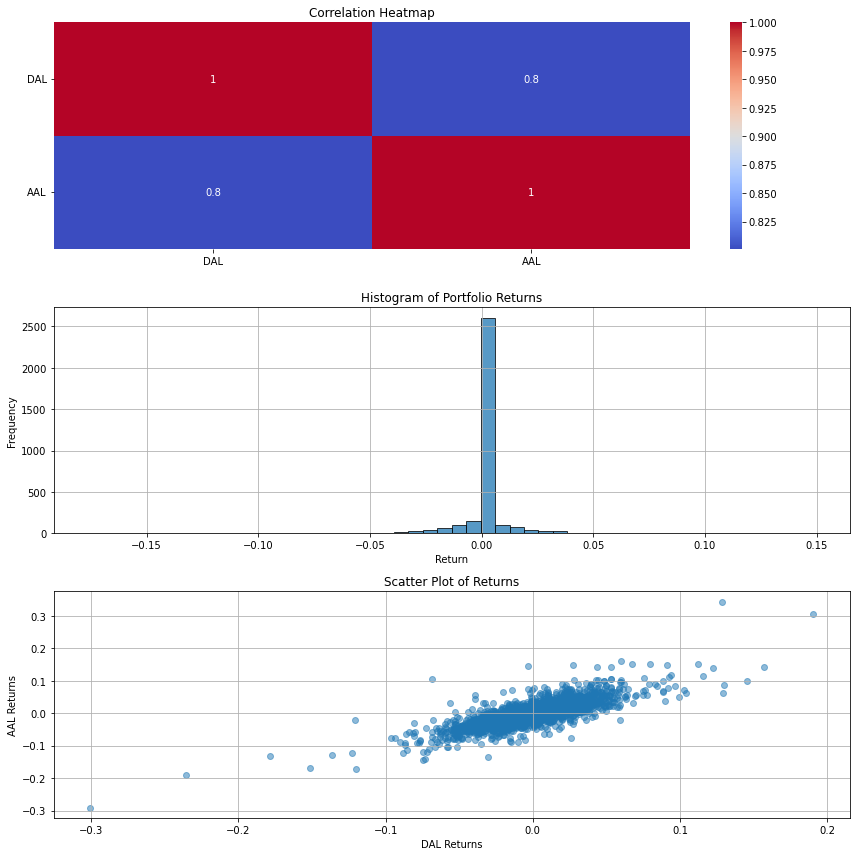

In [25]:
import seaborn as sns

# Calculate the correlation between the two assets' returns
corr_matrix = pd.concat([returns1, returns2], axis=1).corr()

# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False)

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax1)
ax1.set_title('Correlation Heatmap')
ax1.set_xticklabels([symbol1, symbol2], rotation=0)
ax1.set_yticklabels([symbol1, symbol2], rotation=0)

# Plot the histogram of portfolio returns
ax2.hist(portfolio_returns.dropna(), bins=50, edgecolor='black', alpha=0.75)
ax2.set_title('Histogram of Portfolio Returns')
ax2.set_xlabel('Return')
ax2.set_ylabel('Frequency')
ax2.grid()

# Plot the scatter plot of returns
ax3.scatter(returns1, returns2, alpha=0.5)
ax3.set_title('Scatter Plot of Returns')
ax3.set_xlabel(f'{symbol1} Returns')
ax3.set_ylabel(f'{symbol2} Returns')
ax3.grid()

# Display the figure
plt.tight_layout()
plt.show()

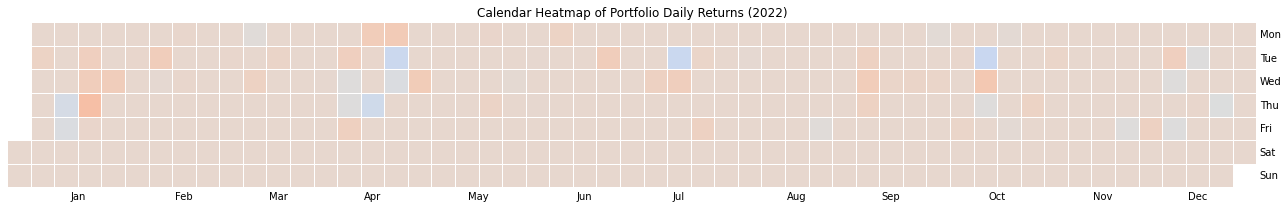

In [26]:
# Calculate daily returns of the portfolio
daily_returns = portfolio_returns.resample('D').mean()

# Create a calendar heatmap
fig, ax = plt.subplots(figsize=(18, 6))
calmap.yearplot(daily_returns, year=2022, ax=ax, cmap='coolwarm', linewidth=1)
ax.set_title('Calendar Heatmap of Portfolio Daily Returns (2022)')

# Display the figure
plt.tight_layout()
plt.show()